Make J-plot from SOHO/LASCO C2 images to track the speed of a solar feature

In [1]:
# %matplotlib notebook
# # %matplotlib ipympl
# # %matplotlib widget
# from ipywidgets import *

# import matplotlib
# print(matplotlib.rcsetup.all_backends)
# matplotlib.use('nbAgg')

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import UnivariateSpline
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from PIL import Image
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import stats
import sunpy.sun.constants as const

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
# start_time = '2024-05-14T16:30:00'
# end_time   = '2024-05-14T18:30:00'

# start_time = '2024-05-14T17:30:00'
# end_time   = '2024-05-14T20:00:00'

# START_DATE, START_TIME = start_time.split('T')
# END_DATE, END_TIME = end_time.split('T')

# START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
# END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

# START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
# END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

data_dir = '/home/mnedal/data'

In [43]:
def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict




def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)

    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec

    # Define the center point of the line (e.g., the center of the map)
    center = map_obj.center

    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point = SkyCoord(center.Tx + line_length * np.cos(angle_rad),
                        center.Ty + line_length * np.sin(angle_rad),
                        frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line



def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]



def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs: list of EUV sunpy maps.
        Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax



def round_obstime(time=None):
    """
    Round the observation time to put it in the image title.
    Input : str, time (HH:MM:SS.sss)
    Output: str, datetime (YYYY-mm-DD HH:MM:SS)
    """
    from datetime import datetime, timedelta

    original_time_str = time

    # Convert the original time string to a datetime object
    original_time = datetime.strptime(original_time_str, '%H:%M:%S.%f')

    # Round the time to the nearest second
    rounded_time = original_time + timedelta(seconds=round(original_time.microsecond / 1e6))

    # Format the rounded time as 'HH:MM:SS'
    rounded_time_str = rounded_time.strftime('%H:%M:%S')
    
    return rounded_time_str



def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects

In [17]:
lasco_c2_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C2')
lasco_c3_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C3')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

In [19]:
# remove redundant images
print(f'Before:\nLASCO C2: {len(lasco_c2_map_objects)}\tLASCO C3: {len(lasco_c3_map_objects)} images\n')

clean_maps_c2 = remove_redundant_maps(lasco_c2_map_objects)
clean_maps_c3 = remove_redundant_maps(lasco_c3_map_objects)

print(f'After:\nLASCO C2: {len(clean_maps_c2)}\tLASCO C3: {len(clean_maps_c3)} images')

Before:
LASCO C2: 150	LASCO C3: 150 images

After:
LASCO C2: 13	LASCO C3: 13 images


In [78]:
m = clean_maps_c2[4]

# Convert SkyCoord to pixel coordinates using the map's WCS
pixel_coords = m.wcs.world_to_pixel(m.center)

# pixel_coords is a tuple (x_pixel, y_pixel)
x_pixel, y_pixel = pixel_coords

print(f"Pixel coordinates: x = {x_pixel}, y = {y_pixel}")

Pixel coordinates: x = 511.49999999999966, y = 511.49999999999875


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


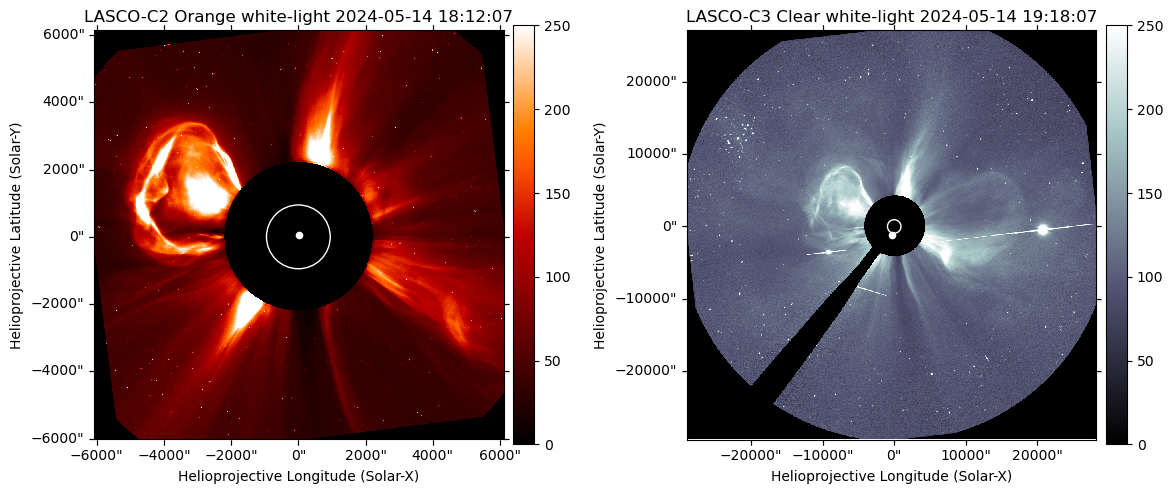

In [81]:
fig = plt.figure(figsize=[12,6])

m = clean_maps_c2[4]
ax = fig.add_subplot(121, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(m.center)
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='w', s=20)
# ax.plot_coord(m.center, color='white', zorder=10)
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)

m = clean_maps_c3[9]
ax = fig.add_subplot(122, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(m.center)
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='w', s=20)
# ax.plot_coord(m.center, color='red', zorder=10)
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)

fig.tight_layout()
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


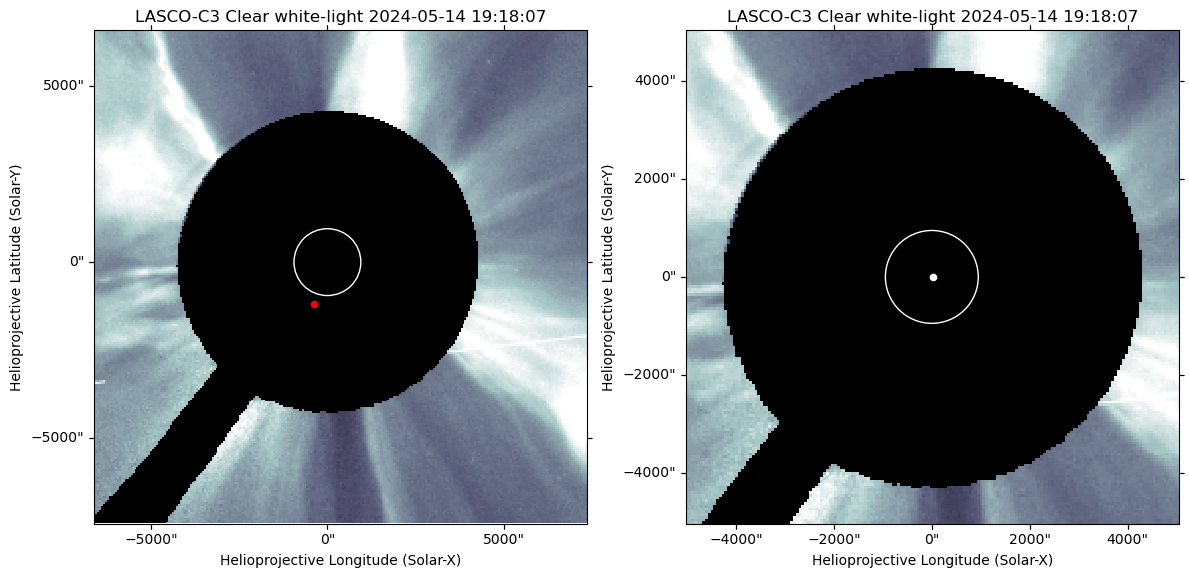

In [105]:
m = clean_maps_c3[9]

crop_length = 5000
top_right = SkyCoord(crop_length * u.arcsec, crop_length * u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-crop_length * u.arcsec, -crop_length * u.arcsec, frame=m.coordinate_frame)
submap = m.submap(bottom_left, top_right=top_right)



fig = plt.figure(figsize=[14,7])

ax = fig.add_subplot(121, projection=m)
m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(m.center)
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='r', s=20)
ax.grid(False)
ax.set_xlim(400, 650)
ax.set_ylim(400, 650)

ax = fig.add_subplot(122, projection=submap)
submap.plot(axes=ax)
submap.draw_limb()
pixel_coords = submap.wcs.world_to_pixel(submap.center)
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='w', s=20)
ax.grid(False)

plt.show()

In [96]:
submap.center

<SkyCoord (Helioprojective: obstime=2024-05-14T19:18:07.601, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2024-05-14T19:18:07.601, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.66373327, 1.51215715e+11)>): (Tx, Ty) in arcsec
    (16.79999996, 1.26311054e-11)>

In [97]:
m.center

<SkyCoord (Helioprojective: obstime=2024-05-14T19:18:07.601, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2024-05-14T19:18:07.601, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.66373327, 1.51215715e+11)>): (Tx, Ty) in arcsec
    (-375.19958618, -1175.98531234)>

In [44]:
# make run-diff maps
m_seq_runratio_c2 = apply_runratio(clean_maps_c2)
m_seq_runratio_c3 = apply_runratio(clean_maps_c3)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


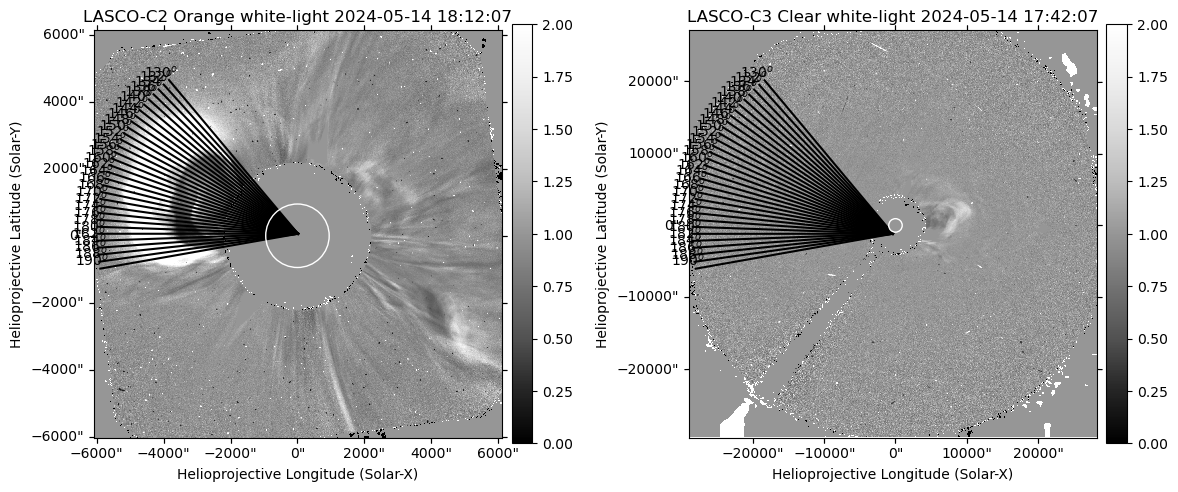

In [53]:
slits = 'True'
centered_list = generate_centered_list(160, 2, 15)

fig = plt.figure(figsize=[12,6])

m = m_seq_runratio_c2[3]
ax = fig.add_subplot(121, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)

if slits:
    for value in centered_list:
        line = plot_line(angle_deg=value, length=6000, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')

m = m_seq_runratio_c3[8]
ax = fig.add_subplot(122, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)

if slits:
    for value in centered_list:
        line = plot_line(angle_deg=value, length=28000, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')

fig.tight_layout()
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


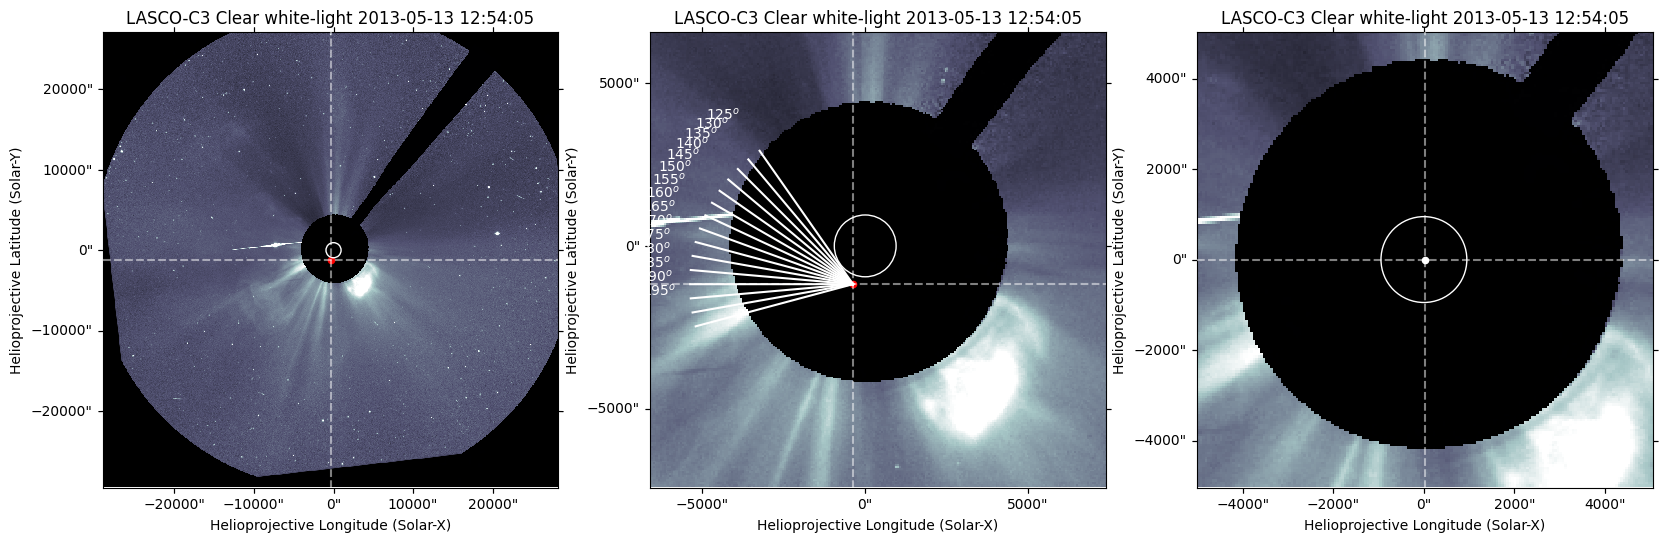

In [5]:
# TEST ...
import warnings
warnings.filterwarnings('ignore')
import hvpy
import numpy as np
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.time import parse_time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize



def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]


def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)

    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec

    # Define the center point of the line (e.g., the center of the map)
    center = map_obj.center

    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point = SkyCoord(center.Tx + line_length * np.cos(angle_rad),
                        center.Ty + line_length * np.sin(angle_rad),
                        frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line



centered_list = generate_centered_list(160, 5, 7)
# 160: is the central slit in deg.
# 2: is the difference in deg. between the slits.
# 15: is the number of slits.

# m: is the sunpy map of LASCO

data = hvpy.getJP2Image(parse_time('2013-05-13 13:00:00').datetime, hvpy.DataSource['LASCO_C3'].value)
file = hvpy.save_file(data, './test_lasco_c3.jp2', overwrite=True)

m = sunpy.map.Map(file)
m.meta['bunit'] = 'ct'
m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)

crop_length = 5000
top_right = SkyCoord(crop_length * u.arcsec, crop_length * u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-crop_length * u.arcsec, -crop_length * u.arcsec, frame=m.coordinate_frame)
submap = m.submap(bottom_left, top_right=top_right)


fig = plt.figure(figsize=[20,7])

ax = fig.add_subplot(131, projection=m)
m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(m.center)
x_pixel, y_pixel = pixel_coords
ax.axvline(x=x_pixel, color='w', linestyle='--', alpha=0.5)
ax.axhline(y=y_pixel, color='w', linestyle='--', alpha=0.5)
ax.scatter(x_pixel, y_pixel, c='r', s=20)
ax.grid(False)

ax = fig.add_subplot(132, projection=m)
m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(m.center)
x_pixel, y_pixel = pixel_coords
ax.axvline(x=x_pixel, color='w', linestyle='--', alpha=0.5)
ax.axhline(y=y_pixel, color='w', linestyle='--', alpha=0.5)
ax.scatter(x_pixel, y_pixel, c='r', s=20)
ax.grid(False)
ax.set_xlim(400, 650)
ax.set_ylim(400, 650)

for value in centered_list:
    line = plot_line(angle_deg=value, length=5000, map_obj=m)
    ax.plot_coord(line, color='w')
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
    
    # Display the number at the end point
    ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$', color='w', fontsize=10, ha='center', va='center')


ax = fig.add_subplot(133, projection=submap)
submap.plot(axes=ax)
submap.draw_limb()
pixel_coords = submap.wcs.world_to_pixel(submap.center)
x_pixel, y_pixel = pixel_coords
ax.axvline(x=x_pixel, color='w', linestyle='--', alpha=0.5)
ax.axhline(y=y_pixel, color='w', linestyle='--', alpha=0.5)
ax.scatter(x_pixel, y_pixel, c='w', s=20)
ax.grid(False)

plt.show()

In [61]:
m.reference_date

AttributeError: 'LASCOMap' object has no attribute 'reference_date'

In [6]:
m.coordinate_frame

<Helioprojective Frame (obstime=2013-05-13T12:54:05.662, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-05-13T12:54:05.662, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.82867308, 1.51175563e+11)>)>

In [8]:
center = m.center
center

<SkyCoord (Helioprojective: obstime=2013-05-13T12:54:05.662, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-05-13T12:54:05.662, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.82867308, 1.51175563e+11)>): (Tx, Ty) in arcsec
    (-375.19958618, -1175.98531234)>

In [12]:
center_pix = m.world_to_pixel(center)
center_pix

PixelPair(x=<Quantity 511.5 pix>, y=<Quantity 511.5 pix>)

In [62]:
from sunpy.coordinates.frames import HeliographicStonyhurst, Helioprojective

sun_center = SkyCoord(HeliographicStonyhurst(0*u.deg, 0*u.deg, obstime=m.date, observer=m.observer))
sun_center

AttributeError: 'LASCOMap' object has no attribute 'observer'

In [47]:
center_pix = m.world_to_pixel(sun_center)
center_pix

PixelPair(x=<Quantity 518.2 pix>, y=<Quantity 533.3403534 pix>)

In [48]:
pixel_coords = m.wcs.world_to_pixel(sun_center)
pixel_coords

(array(518.2), array(533.3403534))

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


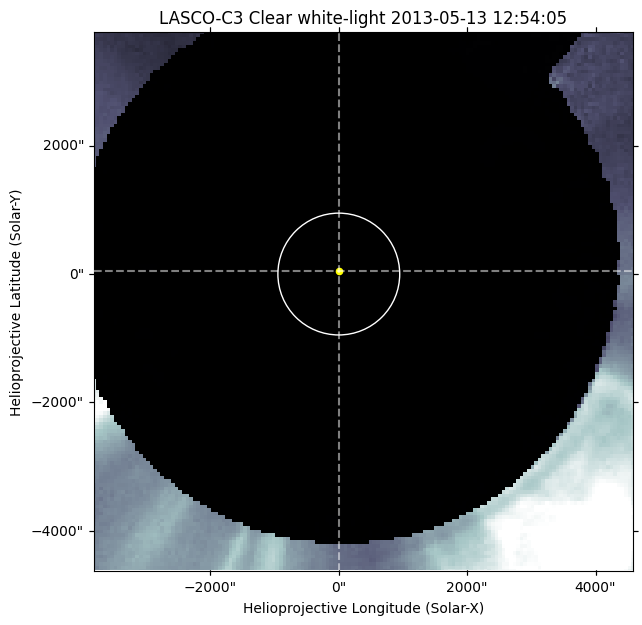

In [46]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(sun_center)
x_pixel, y_pixel = pixel_coords
ax.axvline(x=x_pixel, color='w', linestyle='--', alpha=0.5)
ax.axhline(y=y_pixel, color='w', linestyle='--', alpha=0.5)
ax.scatter(center_pix.x, center_pix.y, c='yellow', s=20)
ax.grid(False)
ax.set_xlim(450, 600)
ax.set_ylim(450, 600)
plt.show()

In [64]:
sun_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame)
sun_center

<SkyCoord (Helioprojective: obstime=2013-05-13T12:54:05.662, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-05-13T12:54:05.662, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.82867308, 1.51175563e+11)>): (Tx, Ty) in arcsec
    (0., 0.)>

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


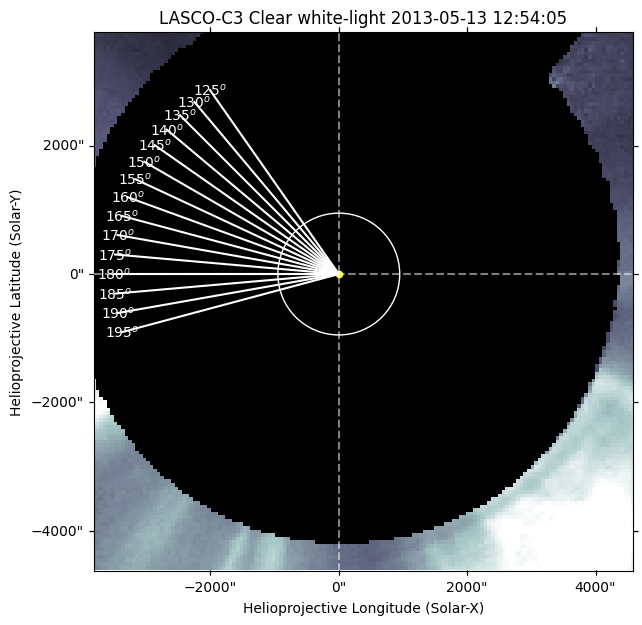

In [72]:
def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)

    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec

    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point = SkyCoord(center.Tx + line_length * np.cos(angle_rad),
                        center.Ty + line_length * np.sin(angle_rad),
                        frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line



fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(sun_center)
x_pixel, y_pixel = pixel_coords
ax.axvline(x=x_pixel, color='w', linestyle='--', alpha=0.5)
ax.axhline(y=y_pixel, color='w', linestyle='--', alpha=0.5)
ax.scatter(x_pixel, y_pixel, c='yellow', s=20)
ax.grid(False)
ax.set_xlim(450, 600)
ax.set_ylim(450, 600)

for value in centered_list:
    line = plot_line(angle_deg=value, length=3500, map_obj=m)
    ax.plot_coord(line, color='w')
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
    
    # Display the number at the end point
    ax.text(end_point_pixel.x.value, end_point_pixel.y.value, f'{value}$^o$', color='w', fontsize=10, ha='center', va='center')

plt.show()

In [73]:
m.center

<SkyCoord (Helioprojective: obstime=2013-05-13T12:54:05.662, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-05-13T12:54:05.662, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.82867308, 1.51175563e+11)>): (Tx, Ty) in arcsec
    (-375.19958618, -1175.98531234)>

In [74]:
SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame)

<SkyCoord (Helioprojective: obstime=2013-05-13T12:54:05.662, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2013-05-13T12:54:05.662, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.82867308, 1.51175563e+11)>): (Tx, Ty) in arcsec
    (0., 0.)>

In [83]:
m.scale.axis1

<Quantity 56. arcsec / pix>

In [80]:
m.meta['crval2']

0.0

Files Downloaded: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02file/s]


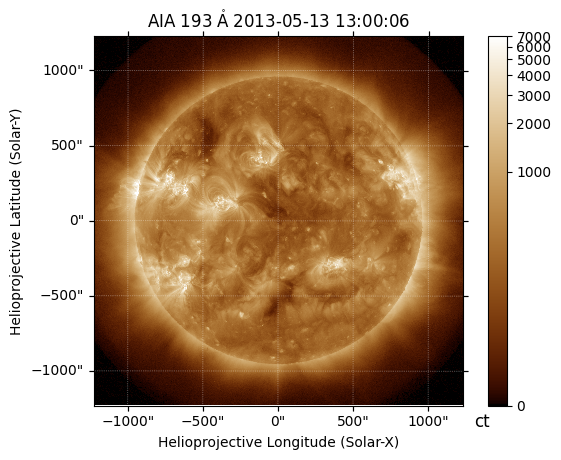

In [52]:
from sunpy.net import Fido, attrs as a

result = Fido.search(a.Time('2013-05-13 13:00:00', '2013-05-13 13:01:00'),
                            a.Instrument('AIA'), 
                            a.Wavelength(193*u.angstrom), 
                            a.Sample(1*u.min))

aia_files = Fido.fetch(result, path='./')
aia = sunpy.map.Map(aia_files[0])
aia.peek(vmin=0, vmax=7000)

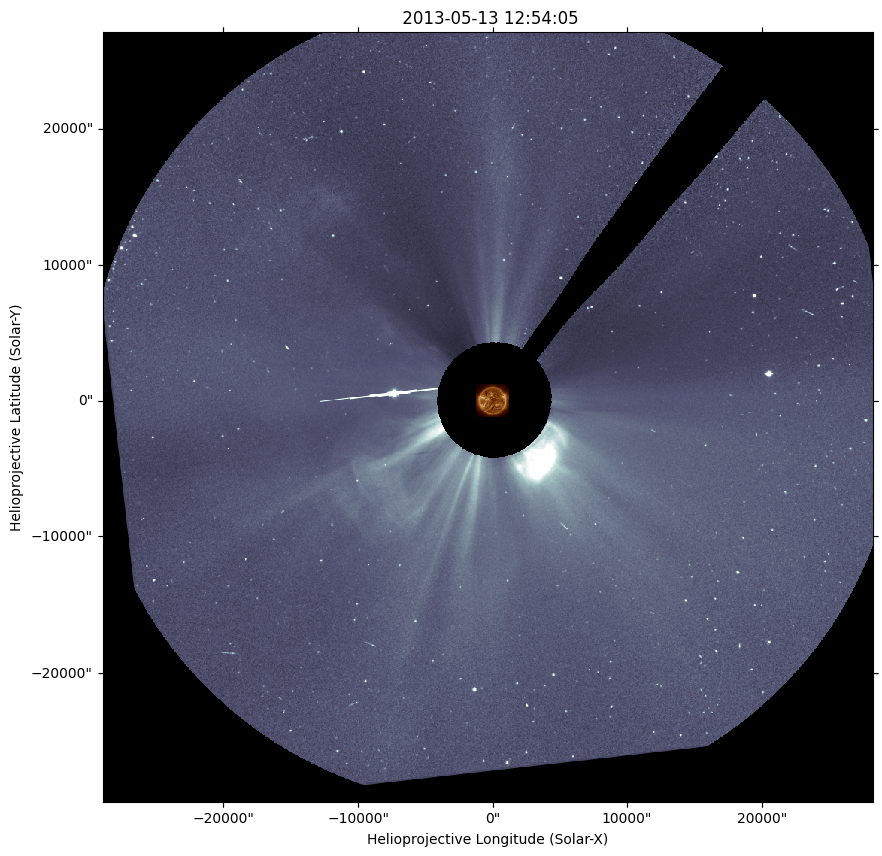

In [55]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=m.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=m.observer_coordinate,
                           rsun=aia.coordinate_frame.rsun)

projected_header = sunpy.map.make_fitswcs_header(aia.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia.scale),
                                                 instrument=aia.instrument,
                                                 wavelength=aia.wavelength)

# We use `assume_spherical_screen` to ensure that the off limb pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(aia.observer_coordinate):
    aia_reprojected = aia.reproject_to(projected_header)




fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
aia_reprojected.plot(axes=ax, autoalign=True)
ax.grid(False)
# ax.set_title(' ')
plt.show()

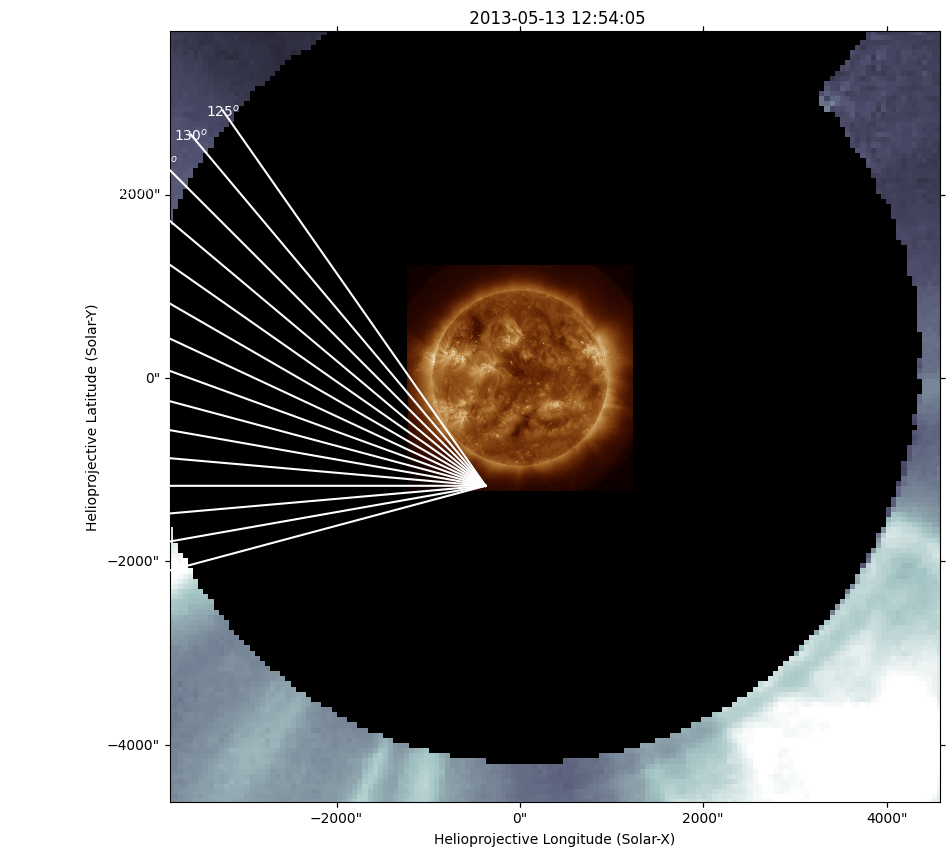

In [59]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
aia_reprojected.plot(axes=ax, autoalign=True)
ax.grid(False)
ax.set_xlim(450, 600)
ax.set_ylim(450, 600)

for value in centered_list:
    line = plot_line(angle_deg=value, length=5000, map_obj=m)
    ax.plot_coord(line, color='w')
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
    
    # Display the number at the end point
    ax.text(end_point_pixel.x.value, end_point_pixel.y.value, f'{value}$^o$', color='w', fontsize=10, ha='center', va='center')

plt.show()

In [ ]:
# Make a dictionary to hold the lists of lists
intensity_dict = {}
distances_dict = {}
output_obj = {}

# Initialize each key with an empty list
for value in centered_list:
    intensity_dict[f'intensity_{value}deg'] = []
    distances_dict[f'distances_{value}deg'] = []
    
    output_obj[f'intensity_{value}deg'] = []
    output_obj[f'distances_{value}deg'] = []

output_obj['time'] = []
output_obj['map_obj'] = []
output_obj['instrument'] = []

for i, m in enumerate(m_seq_runratio_c2):
    print(f'Working on map {i} ..')
    
    norm = ImageNormalize(vmin=0.9, vmax=1.3, stretch=SqrtStretch())
    
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=m)
    m.plot(axes=ax, cmap='Greys_r', norm=norm)
    
    for value in centered_list:
        line = plot_line(angle_deg=value, length=1900, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')
        
        # obtain the coordinates of the map pixels that intersect that path
        intensity_coords_slit = sunpy.map.pixelate_coord_path(m, line)
        
        # Create mask to identify valid coordinates
        valid_mask = sunpy.map.contains_coordinate(m, intensity_coords_slit)
        
        # Apply the mask to filter valid coordinates
        valid_coords = intensity_coords_slit[valid_mask]
        
        # Pass those coordinates to extract the values for those map pixels
        intensity_slit = sunpy.map.sample_at_coords(m, valid_coords)
        
        # Calculate the angular separation between the first point and every other coordinate we extracted
        angular_separation_slit = valid_coords.separation(valid_coords[0]).to(u.arcsec)
        
        # Append the values to the lists
        intensity_dict[f'intensity_{value}deg'].append(list(intensity_slit.value))
        distances_dict[f'distances_{value}deg'].append(list(angular_separation_slit.value))
    
    output_obj['time'].append(m.date.iso)
    output_obj['map_obj'].append(m)
    output_obj['instrument'].append(m.meta['instrume'])
    
    plt.show()

In [20]:
# # read the files names in order
# data = sorted(glob.glob(f'{data_dir}/LASCO_C2/LASCO_C2_{START_YEAR}{START_MONTH}{START_DAY}*.jp2'))
# print(f'\nNumber of fetched images: {len(data)}\n')

In [21]:
# start_file_to_find = f'{data_dir}/LASCO_C2/LASCO_C2_{START_YEAR}{START_MONTH}{START_DAY}T{START_HOUR}{START_MINUTE}.jp2'
# end_file_to_find = f'{data_dir}/LASCO_C2/LASCO_C2_{START_YEAR}{START_MONTH}{START_DAY}T{END_HOUR}{END_MINUTE}.jp2'

# idx1 = data.index(start_file_to_find)
# idx2 = data.index(end_file_to_find)

# print(f'Index of the first image {start_file_to_find} is {idx1}')
# print(f'Index of the last image {end_file_to_find} is {idx2}')

In [22]:
# map_objects = data[idx1:idx2]
# print(len(map_objects))

In [6]:
# map_obj.meta['bunit'] = 'ct' # a workaround for C2 jp2 images
# map_obj.peek()

In [41]:
# img_index = 1

# file = map_objects[img_index]
# map_obj = sunpy.map.Map(file)

In [42]:
# min_range = 0
# max_range = 250
# map_obj.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range)

# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(111, projection=map_obj)
# img = map_obj.plot(axes=ax)
# ax.grid(False)
# fig.colorbar(img, pad=0.02, shrink=0.8)
# plt.show()

In [9]:
# def make_slit(x1=None, x2=None, y1=None, y2=None, map_obj=None):
#     slit_coords = SkyCoord(
#             Tx=(x1, x2)*u.arcsec,
#             Ty=(y1, y2)*u.arcsec,
#             frame=map_obj.coordinate_frame)
#     return slit_coords

In [10]:
# slit_x1 = 2000
# slit_x2 = 6000
# slit_y1 = 0
# slit_y2 = 100

# slit_coords = make_slit(x1=slit_x1, x2=slit_x2, y1=slit_y1, y2=slit_y2, map_obj=map_obj)

# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(111, projection=map_obj)
# map_obj.plot(axes=ax)
# ax.plot_coord(slit_coords, color='cyan', linestyle='--', linewidth=2)
# ax.grid(False)
# plt.show()

In [11]:
# # loop over the maps to extract the intensity along the slit
# intensity_values_slit = []
# distances_slit = []
# times = []

# for i, m in enumerate(map_objects):
#     print(f'{i} Working on {m} ..')
#     map_obj = sunpy.map.Map(m)
#     map_obj.meta['bunit'] = 'ct' # a workaround for C2 jp2 images
#     map_obj.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
    
#     slit_coords = SkyCoord(
#             Tx=(slit_x1, slit_x2)*u.arcsec,
#             Ty=(slit_y1, slit_y2)*u.arcsec,
#             frame=map_obj.coordinate_frame)

#     # obtain the coordinates of the map pixels that intersect that path
#     intensity_coords_slit = sunpy.map.pixelate_coord_path(map_obj, slit_coords)
#     # Pass those coordinates to extract the values for those map pixels
#     intensity_slit = sunpy.map.sample_at_coords(map_obj, intensity_coords_slit)
    
# #     print(intensity_slit)
    
#     # Calculate the angular separation between the first point and every other coordinate we extracted
#     angular_separation_slit = intensity_coords_slit.separation(intensity_coords_slit[0]).to(u.arcsec)
#     # Append the values to the lists
#     intensity_values_slit.append(intensity_slit)
#     distances_slit.append(angular_separation_slit)
#     times.append(map_obj.date.iso)

# # Convert lists to numpy arrays
# intensity_values_slit_arr = np.array(intensity_values_slit)
# distances_slit_arr = np.array(distances_slit)
# times_arr = np.array(times)

# output_obj = {
#     'intensity': intensity_values_slit_arr.T,
#     'distance': distances_slit_arr,
#     'time': times_arr,
#     'map_obj': map_obj,
#     'instrument': map_obj.meta['instrume'],
#     'detector': map_obj.meta['detector']
# }

In [39]:
# # plot the j-plot
# fig = plt.figure(figsize=[10,5])
# ax = fig.add_subplot(111)
# img = ax.imshow(output_obj['intensity'], aspect='auto', origin='lower',
#                 cmap='seismic',
# #                 vmin=0, vmax=0.7,
#         extent=[mdates.date2num(pd.Timestamp(str(output_obj['time'][0]))),
#                 mdates.date2num(pd.Timestamp(str(output_obj['time'][-1]))),
#                 output_obj['distance'][0,:][0],
#                 output_obj['distance'][0,:][-1]])

# # Add vertical lines at the borders of each column
# datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# for col in datenum_arr:
#     ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Angular distance (arcsec)')
# ax.set_title(f"J-plot of {output_obj['instrument']} {output_obj['detector']} Intensity Along the Slit")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # ax.set_xlim(left=pd.Timestamp(f"{output_obj['map_obj'].meta['date-obs'].split('T')[0]} 16:46"),
# #             right=pd.Timestamp(f"{output_obj['map_obj'].meta['date-obs'].split('T')[0]} 18:30"))
# # ax.set_ylim(top=510, bottom=250)
# fig.colorbar(img, pad=0.02)
# plt.show()

### Tracing the jet

In [40]:
# # plot the j-plot
# fig = plt.figure(figsize=[8,5])
# ax = fig.add_subplot(111)
# ax.imshow(output_obj['intensity'], aspect='auto', origin='lower',
#                 cmap='seismic',
#         extent=[mdates.date2num(pd.Timestamp(str(output_obj['time'][0]))),
#                 mdates.date2num(pd.Timestamp(str(output_obj['time'][-1]))),
#                 output_obj['distance'][0,:][0],
#                 output_obj['distance'][0,:][-1]])

# # Add vertical lines at the borders of each column
# datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# for col in datenum_arr:
#     ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Angular distance (arcsec)')
# ax.set_title(f"J-plot of {output_obj['instrument']} {output_obj['detector']} Intensity Along the Slit")
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # List to store coordinates
# feature_coords_slit = []

# # Function to be called when a mouse button is pressed
# def onclick(event):
#     if event.inaxes == ax:
#         if event.button == 1:  # Left mouse button
#             # Get the x and y coordinates
#             x, y = event.xdata, event.ydata
#             feature_coords_slit.append((x, y))
#             ax.plot(x, y, 'ko')  # Mark the point with a red dot
#             fig.canvas.draw()
#         elif event.button == 3:  # Right mouse button
#             # Disconnect the click event and exit the canvas
#             fig.canvas.mpl_disconnect(cid)

# # Connect the click event to the onclick function
# cid = fig.canvas.mpl_connect('button_press_event', onclick)
# plt.show()

In [143]:
df_jplot = pd.DataFrame(feature_coords_slit, columns=['time','distance'])
df_jplot

time     distance
0  19857.708744  1008.382412
1  19857.715556  3206.122258

In [144]:
df_jplot.to_pickle(f"{data_dir}/jplot_data_{output_obj['instrument']}_{output_obj['detector']}_{output_obj['time'][0].split(' ')[0]}_event{event_num}.csv")
print(f"J-plot data saved at: {data_dir}/jplot_data_{output_obj['instrument']}_{output_obj['detector']}_{output_obj['time'][0].split(' ')[0]}_event{event_num}.csv")

J-plot data saved at: /home/mnedal/data/jplot_data_LASCO_C2_2024-05-14_event1.csv


### Fitting the points

In [145]:
# Extract time and distance arrays from the selected coordinates
times_f, distances = zip(*feature_coords_slit)

# Convert times to matplotlib date numbers
times_num = np.array(times_f)

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'].rsun_obs
print(conversion_factor)

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.0998119800904 km / arcsec


In [146]:
# convert distance from arcsec to km
df_jplot['distance_km'] = df_jplot['distance'] * conversion_factor

# calculate the distance difference in km
df_jplot['distance_diff_km'] = df_jplot['distance_km'].diff()

# convert time to datetime format
df_jplot['datetime'] = [mdates.num2date(t) for t in df_jplot['time']]

# calculate the time difference in seconds
df_jplot['time_diff_s'] = df_jplot['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df_jplot['speed_km_s'] = df_jplot['distance_diff_km'] / df_jplot['time_diff_s']

# drop the first row which will have NaN values for the differences
df_jplot.dropna(inplace=True)

In [147]:
df_jplot.head()

time     distance   distance_km  distance_diff_km  \
1  19857.715556  3206.122258  2.350408e+06      1.611163e+06   

                          datetime  time_diff_s   speed_km_s  
1 2024-05-14 17:10:24.042119+00:00     588.5763  2737.389644

<IPython.core.display.Javascript object>


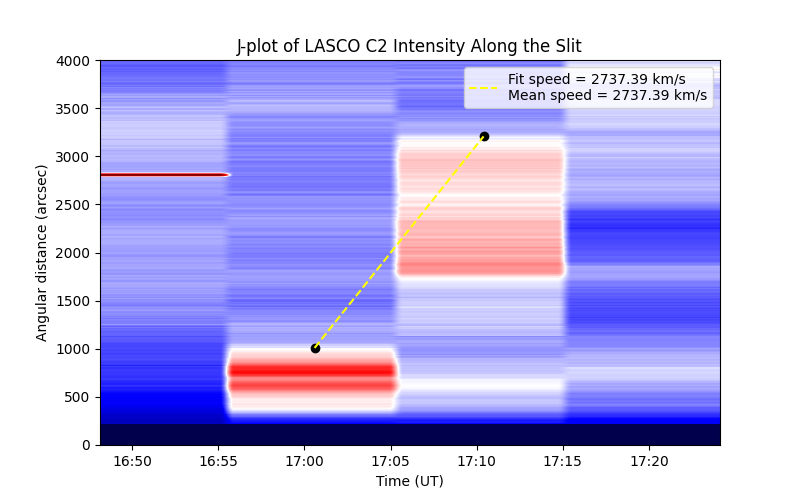

In [149]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[mdates.date2num(pd.Timestamp(str(output_obj['time'][0]))),
                mdates.date2num(pd.Timestamp(str(output_obj['time'][-1]))),
                output_obj['distance'][0,:][0],
                output_obj['distance'][0,:][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# Plot the fitted line
fit_line = slope * np.array(times_num) + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s

# Plot the selected points
ax.plot(times_num, distances, 'ko')
speed = df_jplot['speed_km_s'].mean()
ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Fit speed = {speed_fit:.2f} km/s\nMean speed = {speed:.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument']} {output_obj['detector']} Intensity Along the Slit")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend()
ax.set_ylim(top=4000)
plt.show()

# Apply running ratio

In [39]:
print(len(map_objects))

150


In [40]:
map_objects[0]

'/home/mnedal/data/LASCO_C2/LASCO_C2_20240514T1730.jp2'

In [48]:
# load the files as sunpy maps
maps = []
for m in map_objects:
    map_obj = sunpy.map.Map(m)
    map_obj.meta['bunit'] = 'ct' # a workaround for C2 jp2 images
    map_obj.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
    maps.append(map_obj)

In [49]:
def remove_redundant_maps(maps):
    '''
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    '''
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())

In [50]:
clean_maps = remove_redundant_maps(maps)
len(clean_maps)

13

In [51]:
# make running-ratio images
def apply_runratio(maps):
    '''
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
    Inputs: list of EUV sunpy maps.
    Output: sequence of run-ratio sunpy maps.
    '''    
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    return m_seq_runratio

In [52]:
# # visual inspection one by one
# for i, m in enumerate(clean_maps):
#     fig = plt.figure(figsize=[5,5])
#     fig.suptitle(f'map: {i}')
#     ax = fig.add_subplot(111, projection=m)
#     m.plot(axes=ax)
#     ax.grid(False)
#     plt.show()

In [56]:
m_seq_runratio = apply_runratio(clean_maps)

for m in m_seq_runratio:
    m.data[np.isnan(m.data)] = 1
    # m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())
    m.plot_settings['cmap'] = 'seismic'

print(len(m_seq_runratio))

12


<IPython.core.display.Javascript object>


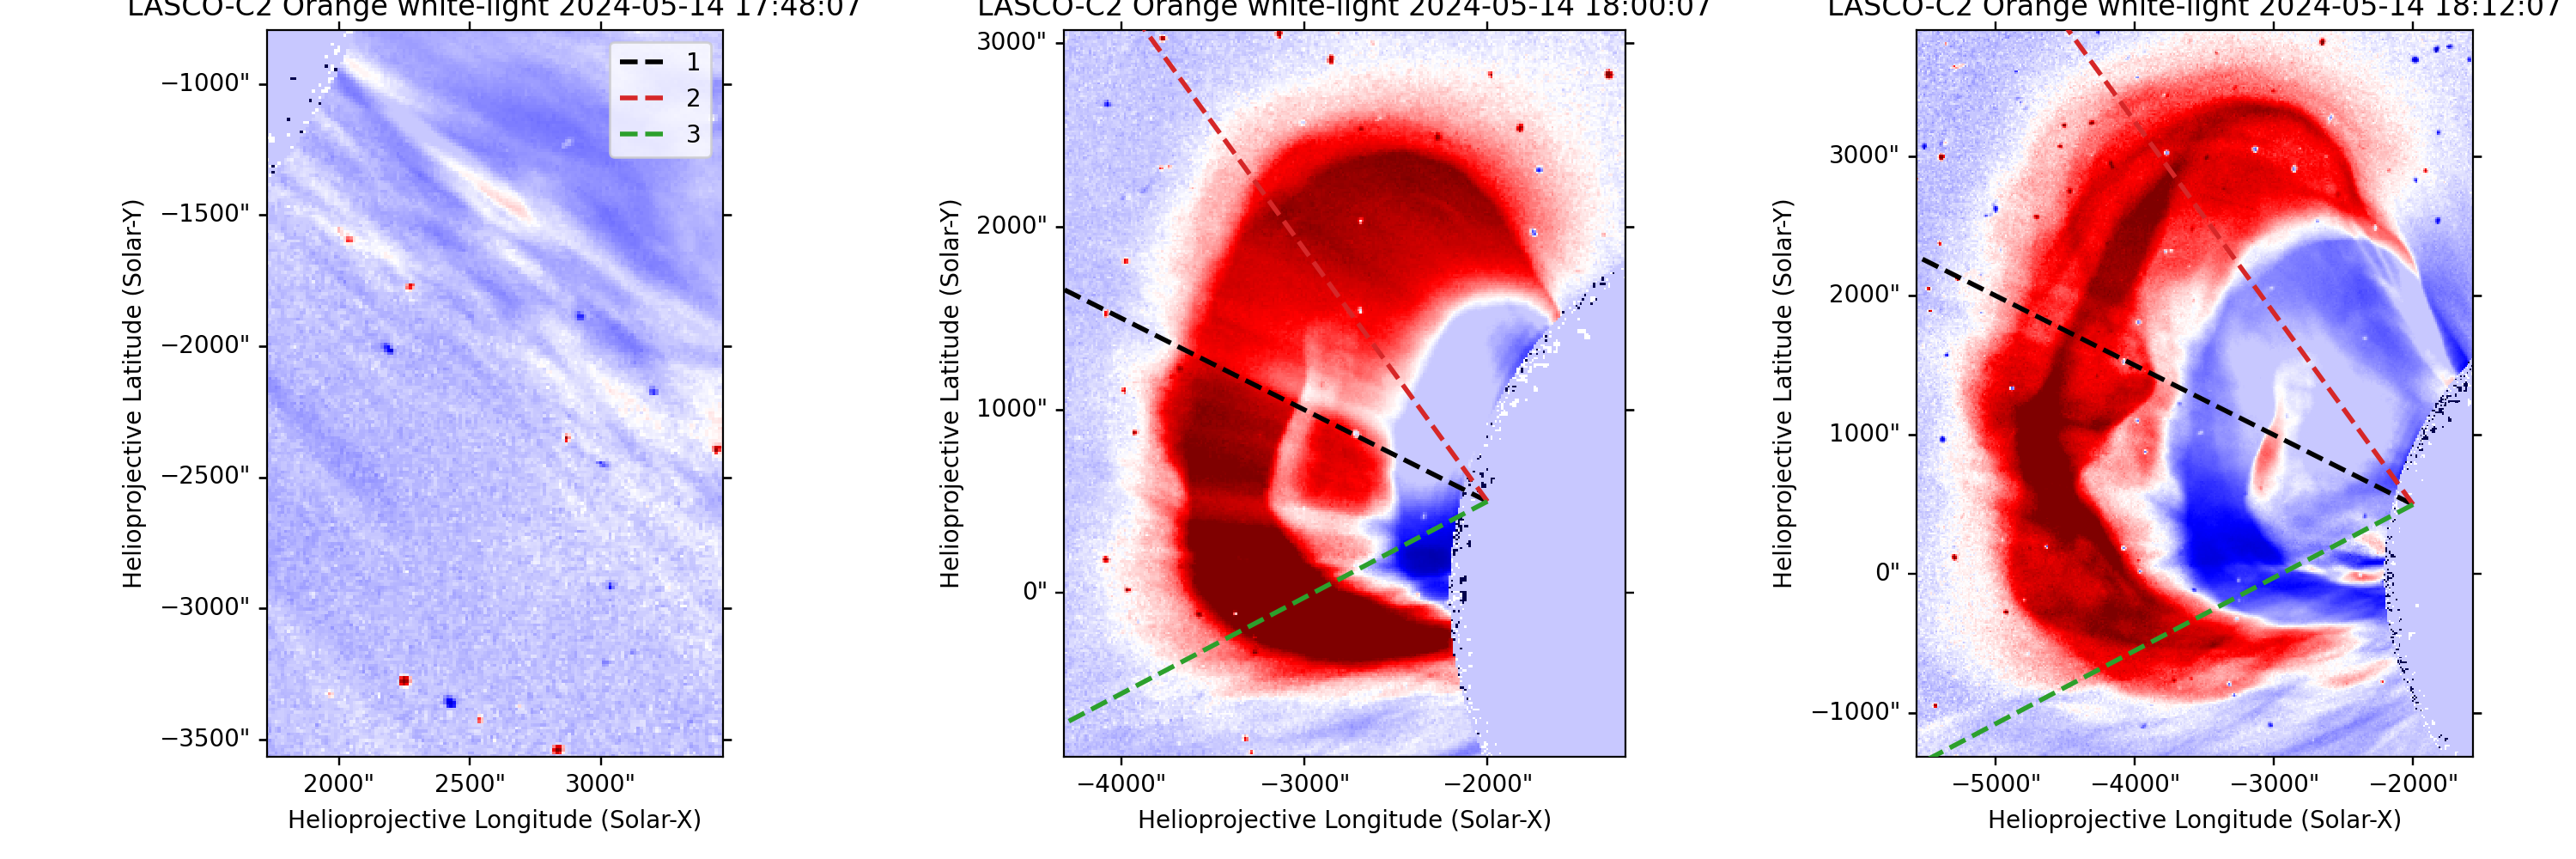

In [65]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(131, projection=m_seq_runratio[1])
m_seq_runratio[1].plot(axes=ax)
ax.grid(False)

slit1_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=2500, map_obj=m_seq_runratio[1])
slit2_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=6000, map_obj=m_seq_runratio[1])
slit3_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=-1600, map_obj=m_seq_runratio[1])

ax.plot_coord(slit1_coords, color='black', linestyle='--', linewidth=2, label='1')
ax.plot_coord(slit2_coords, color='tab:red', linestyle='--', linewidth=2, label='2')
ax.plot_coord(slit3_coords, color='tab:green', linestyle='--', linewidth=2, label='3')

ax.legend()

ax = fig.add_subplot(132, projection=m_seq_runratio[2])
m_seq_runratio[2].plot(axes=ax)
ax.grid(False)

slit1_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=2500, map_obj=m_seq_runratio[2])
slit2_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=6000, map_obj=m_seq_runratio[2])
slit3_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=-1600, map_obj=m_seq_runratio[2])

ax.plot_coord(slit1_coords, color='black', linestyle='--', linewidth=2, label='1')
ax.plot_coord(slit2_coords, color='tab:red', linestyle='--', linewidth=2, label='2')
ax.plot_coord(slit3_coords, color='tab:green', linestyle='--', linewidth=2, label='3')

ax = fig.add_subplot(133, projection=m_seq_runratio[3])
m_seq_runratio[3].plot(axes=ax)
ax.grid(False)

slit1_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=2500, map_obj=m_seq_runratio[3])
slit2_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=6000, map_obj=m_seq_runratio[3])
slit3_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=-1600, map_obj=m_seq_runratio[3])

ax.plot_coord(slit1_coords, color='black', linestyle='--', linewidth=2, label='1')
ax.plot_coord(slit2_coords, color='tab:red', linestyle='--', linewidth=2, label='2')
ax.plot_coord(slit3_coords, color='tab:green', linestyle='--', linewidth=2, label='3')

plt.tight_layout()
plt.show()

In [66]:
# loop over the maps to extract the intensity along the slit
intensity_values_slit1 = []
intensity_values_slit2 = []
intensity_values_slit3 = []

distances_slit1 = []
distances_slit2 = []
distances_slit3 = []

times = []

for i, map_obj in enumerate(clean_maps):
    print(f'Working on map {i} ..')
    
    slit1_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=2500, map_obj=map_obj)
    slit2_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=6000, map_obj=map_obj)
    slit3_coords = make_slit(x1=-2000, x2=-6000, y1=500, y2=-1600, map_obj=map_obj)
    
    # obtain the coordinates of the map pixels that intersect that path
    intensity_coords_slit1 = sunpy.map.pixelate_coord_path(map_obj, slit1_coords)
    # Pass those coordinates to extract the values for those map pixels
    intensity_slit1 = sunpy.map.sample_at_coords(map_obj, intensity_coords_slit1)
    # Calculate the angular separation between the first point and every other coordinate we extracted
    angular_separation_slit1 = intensity_coords_slit1.separation(intensity_coords_slit1[0]).to(u.arcsec)
    # Append the values to the lists
    intensity_values_slit1.append(intensity_slit1)
    distances_slit1.append(angular_separation_slit1)
    
    # obtain the coordinates of the map pixels that intersect that path
    intensity_coords_slit2 = sunpy.map.pixelate_coord_path(map_obj, slit2_coords)
    # Pass those coordinates to extract the values for those map pixels
    intensity_slit2 = sunpy.map.sample_at_coords(map_obj, intensity_coords_slit2)
    # Calculate the angular separation between the first point and every other coordinate we extracted
    angular_separation_slit2 = intensity_coords_slit2.separation(intensity_coords_slit2[0]).to(u.arcsec)
    # Append the values to the lists
    intensity_values_slit2.append(intensity_slit2)
    distances_slit2.append(angular_separation_slit2)
    
    # obtain the coordinates of the map pixels that intersect that path
    intensity_coords_slit3 = sunpy.map.pixelate_coord_path(map_obj, slit3_coords)
    # Pass those coordinates to extract the values for those map pixels
    intensity_slit3 = sunpy.map.sample_at_coords(map_obj, intensity_coords_slit3)
    # Calculate the angular separation between the first point and every other coordinate we extracted
    angular_separation_slit3 = intensity_coords_slit3.separation(intensity_coords_slit3[0]).to(u.arcsec)
    # Append the values to the lists
    intensity_values_slit3.append(intensity_slit3)
    distances_slit3.append(angular_separation_slit3)
    
    times.append(map_obj.date.iso)

# Convert lists to numpy arrays
intensity_values_slit1_arr = np.array(intensity_values_slit1)
distances_slit1_arr = np.array(distances_slit1)[0,:]

intensity_values_slit2_arr = np.array(intensity_values_slit2)
distances_slit2_arr = np.array(distances_slit2)[0,:]

intensity_values_slit3_arr = np.array(intensity_values_slit3)
distances_slit3_arr = np.array(distances_slit3)[0,:]

times_arr = np.array(times)

output_obj = {
    'intensity1': intensity_values_slit1_arr.T,
    'intensity2': intensity_values_slit2_arr.T,
    'intensity3': intensity_values_slit3_arr.T,
    'distance1': distances_slit1_arr,
    'distance2': distances_slit2_arr,
    'distance3': distances_slit3_arr,
    'time': times_arr,
    'map_obj': map_obj,
    'instrument': map_obj.meta['instrume'],
    'detector': map_obj.meta['detector']
}

Working on map 0 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 1 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 3 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 4 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 5 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 6 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Working on map 7 ..
INFO: Missing metadata for solar radius: assuming the standard radius 

<IPython.core.display.Javascript object>


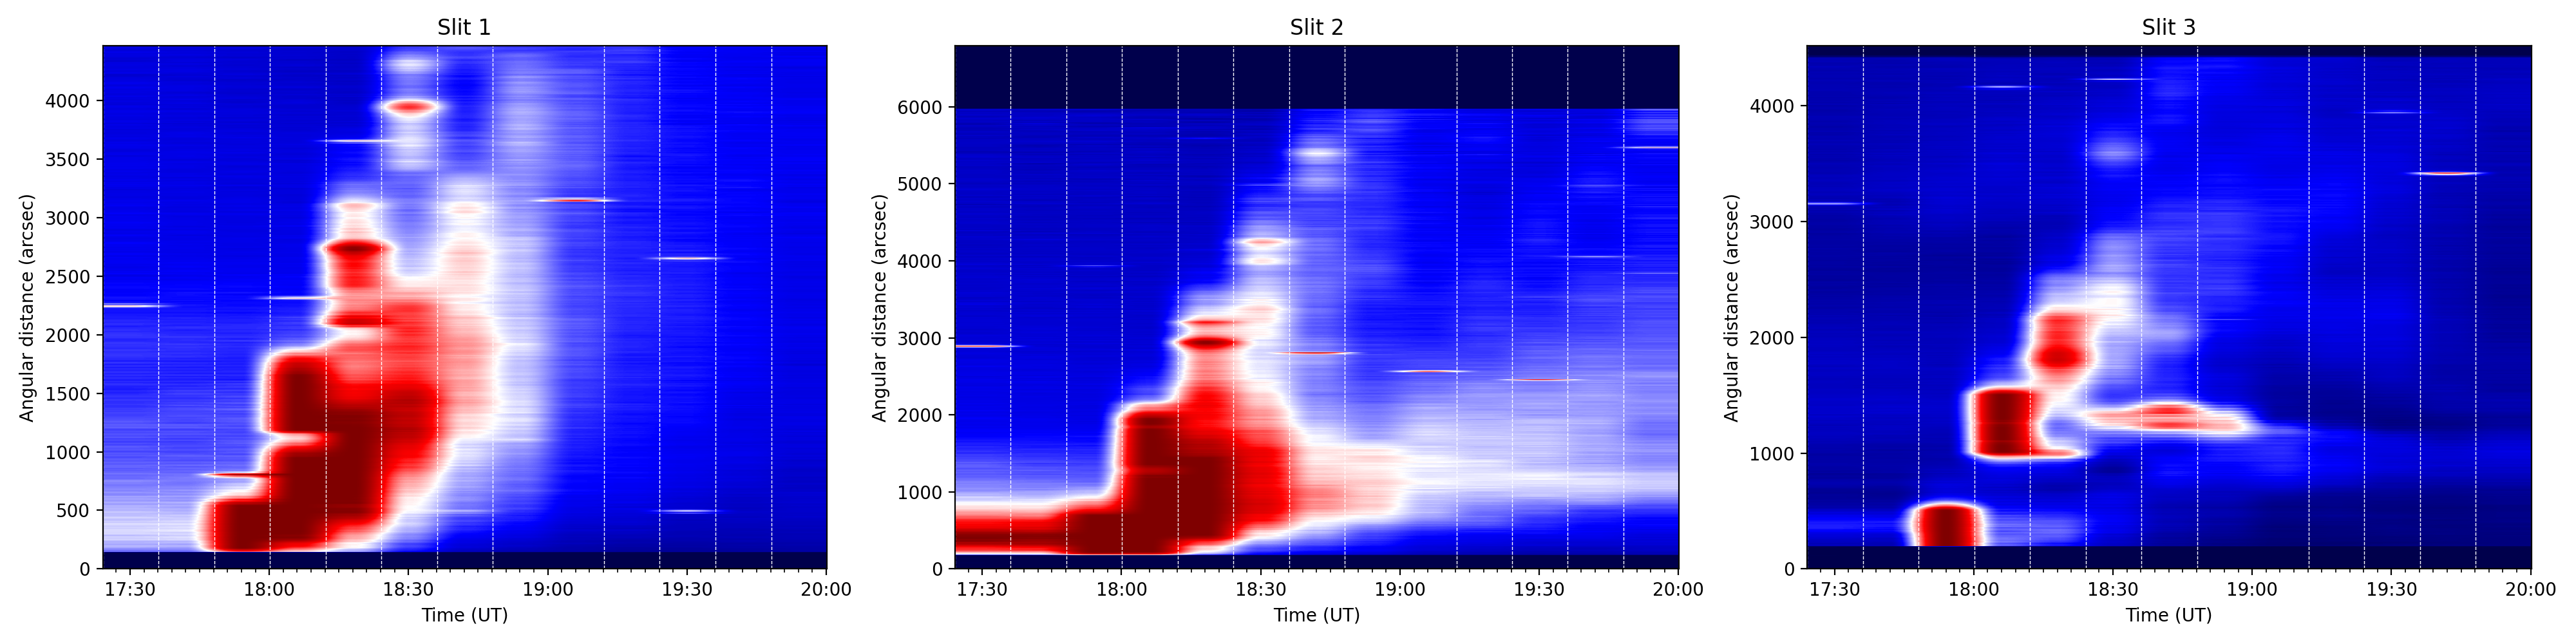

In [71]:
# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

fig = plt.figure(figsize=[20,5])

ax = fig.add_subplot(131)
ax.imshow(output_obj['intensity1'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance1'][0],
                output_obj['distance1'][-1]])
for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 1')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

ax = fig.add_subplot(132)
ax.imshow(output_obj['intensity2'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance2'][0],
                output_obj['distance2'][-1]])
for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 2')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

ax = fig.add_subplot(133)
ax.imshow(output_obj['intensity3'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance3'][0],
                output_obj['distance3'][-1]])
for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 3')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

fig.tight_layout()
plt.show()

## Clicking ...

<IPython.core.display.Javascript object>


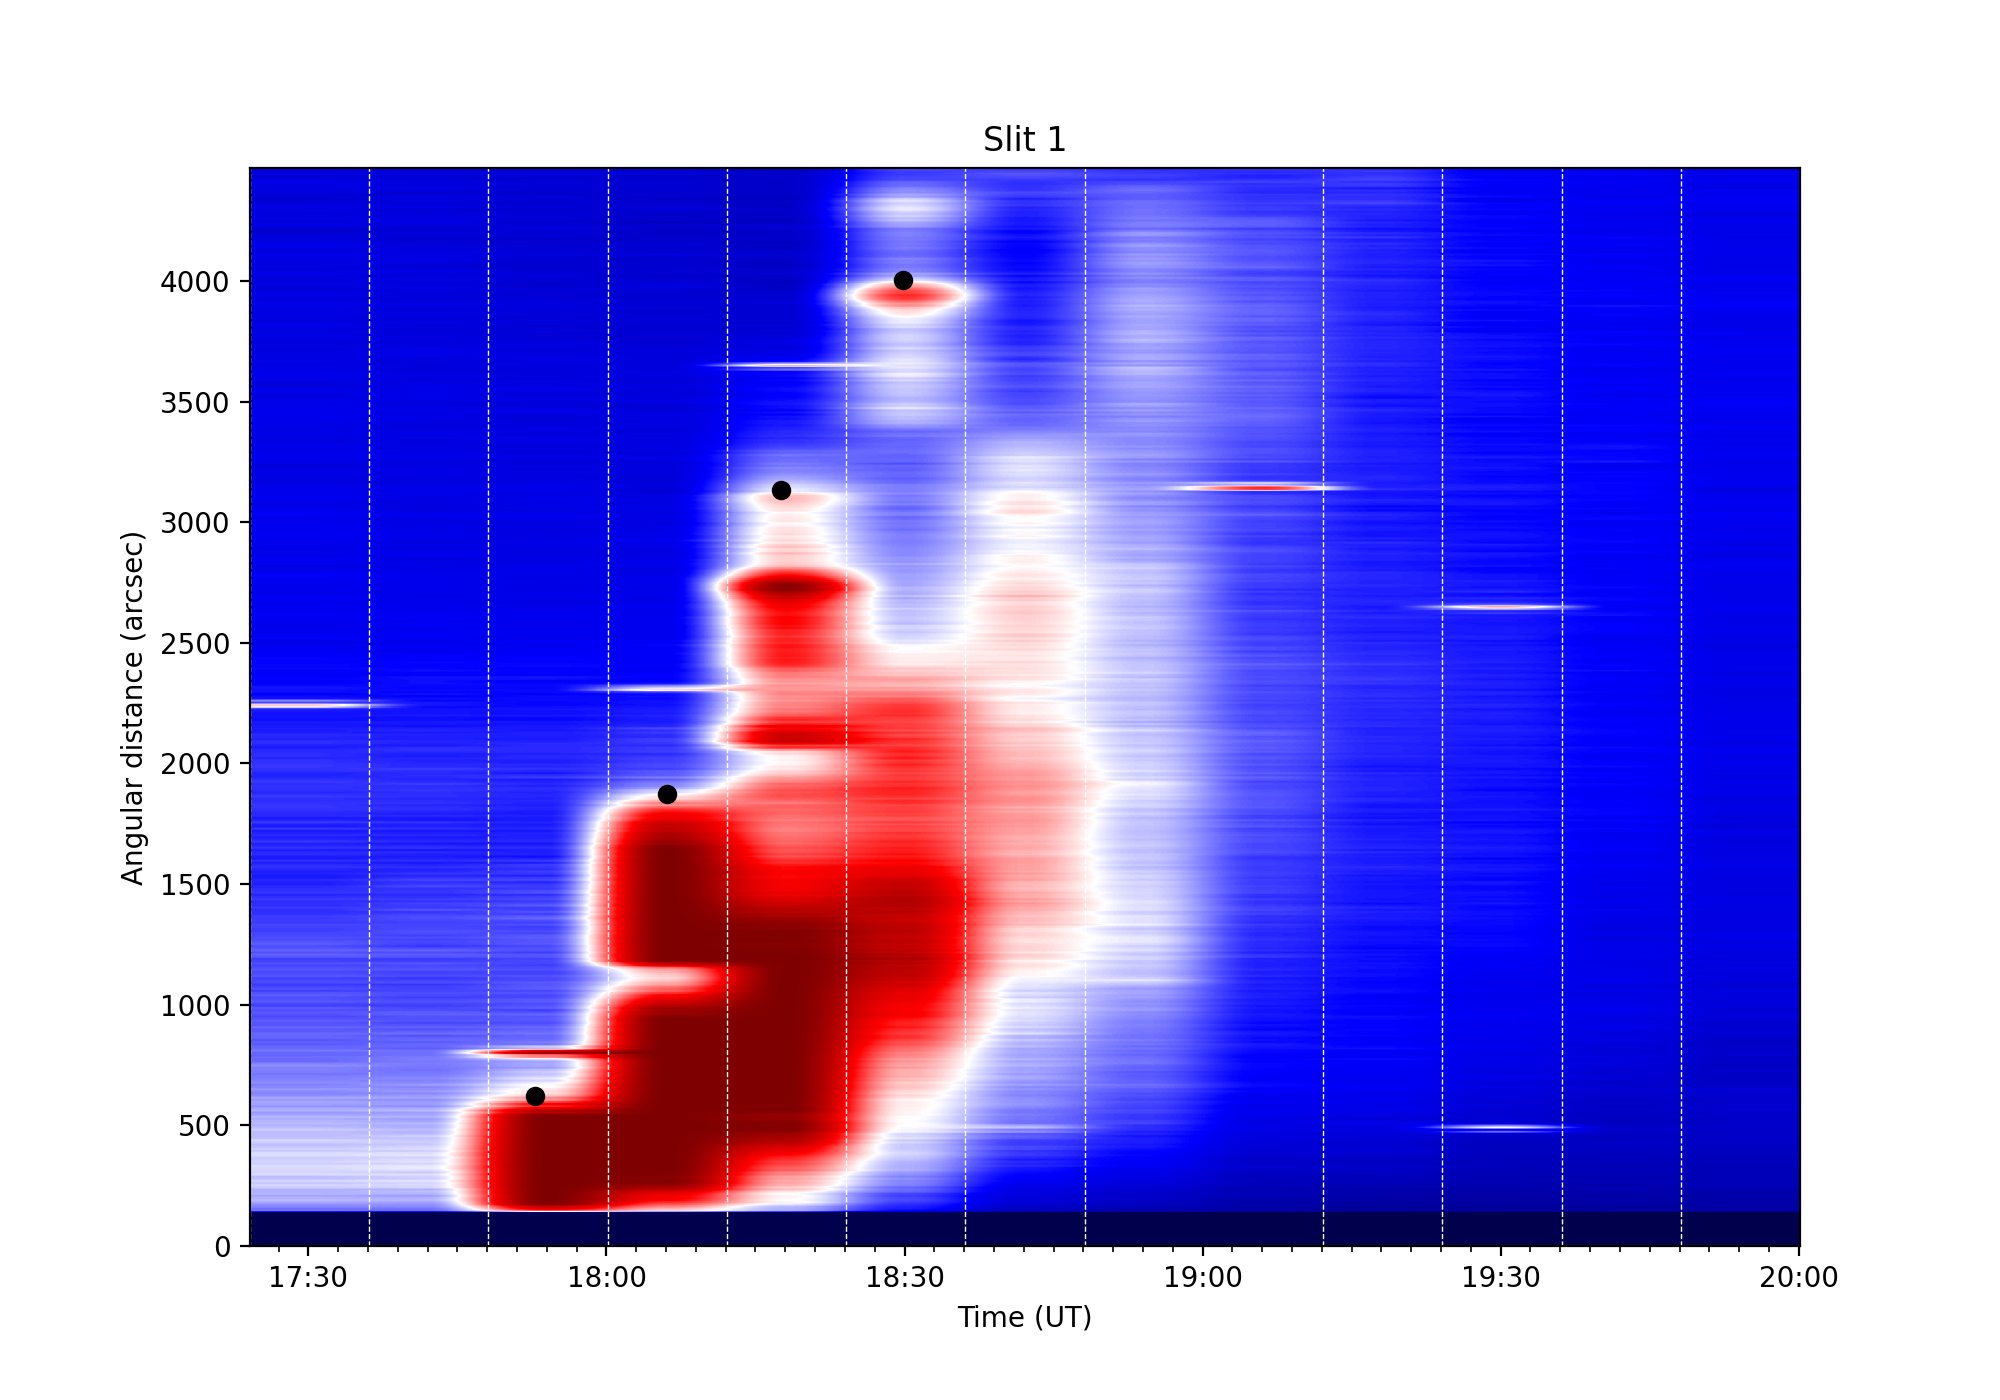

In [72]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity1'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance1'][0],
                output_obj['distance1'][-1]])

for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 1')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

# List to store coordinates
feature_coords_slit1 = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            feature_coords_slit1.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

<IPython.core.display.Javascript object>


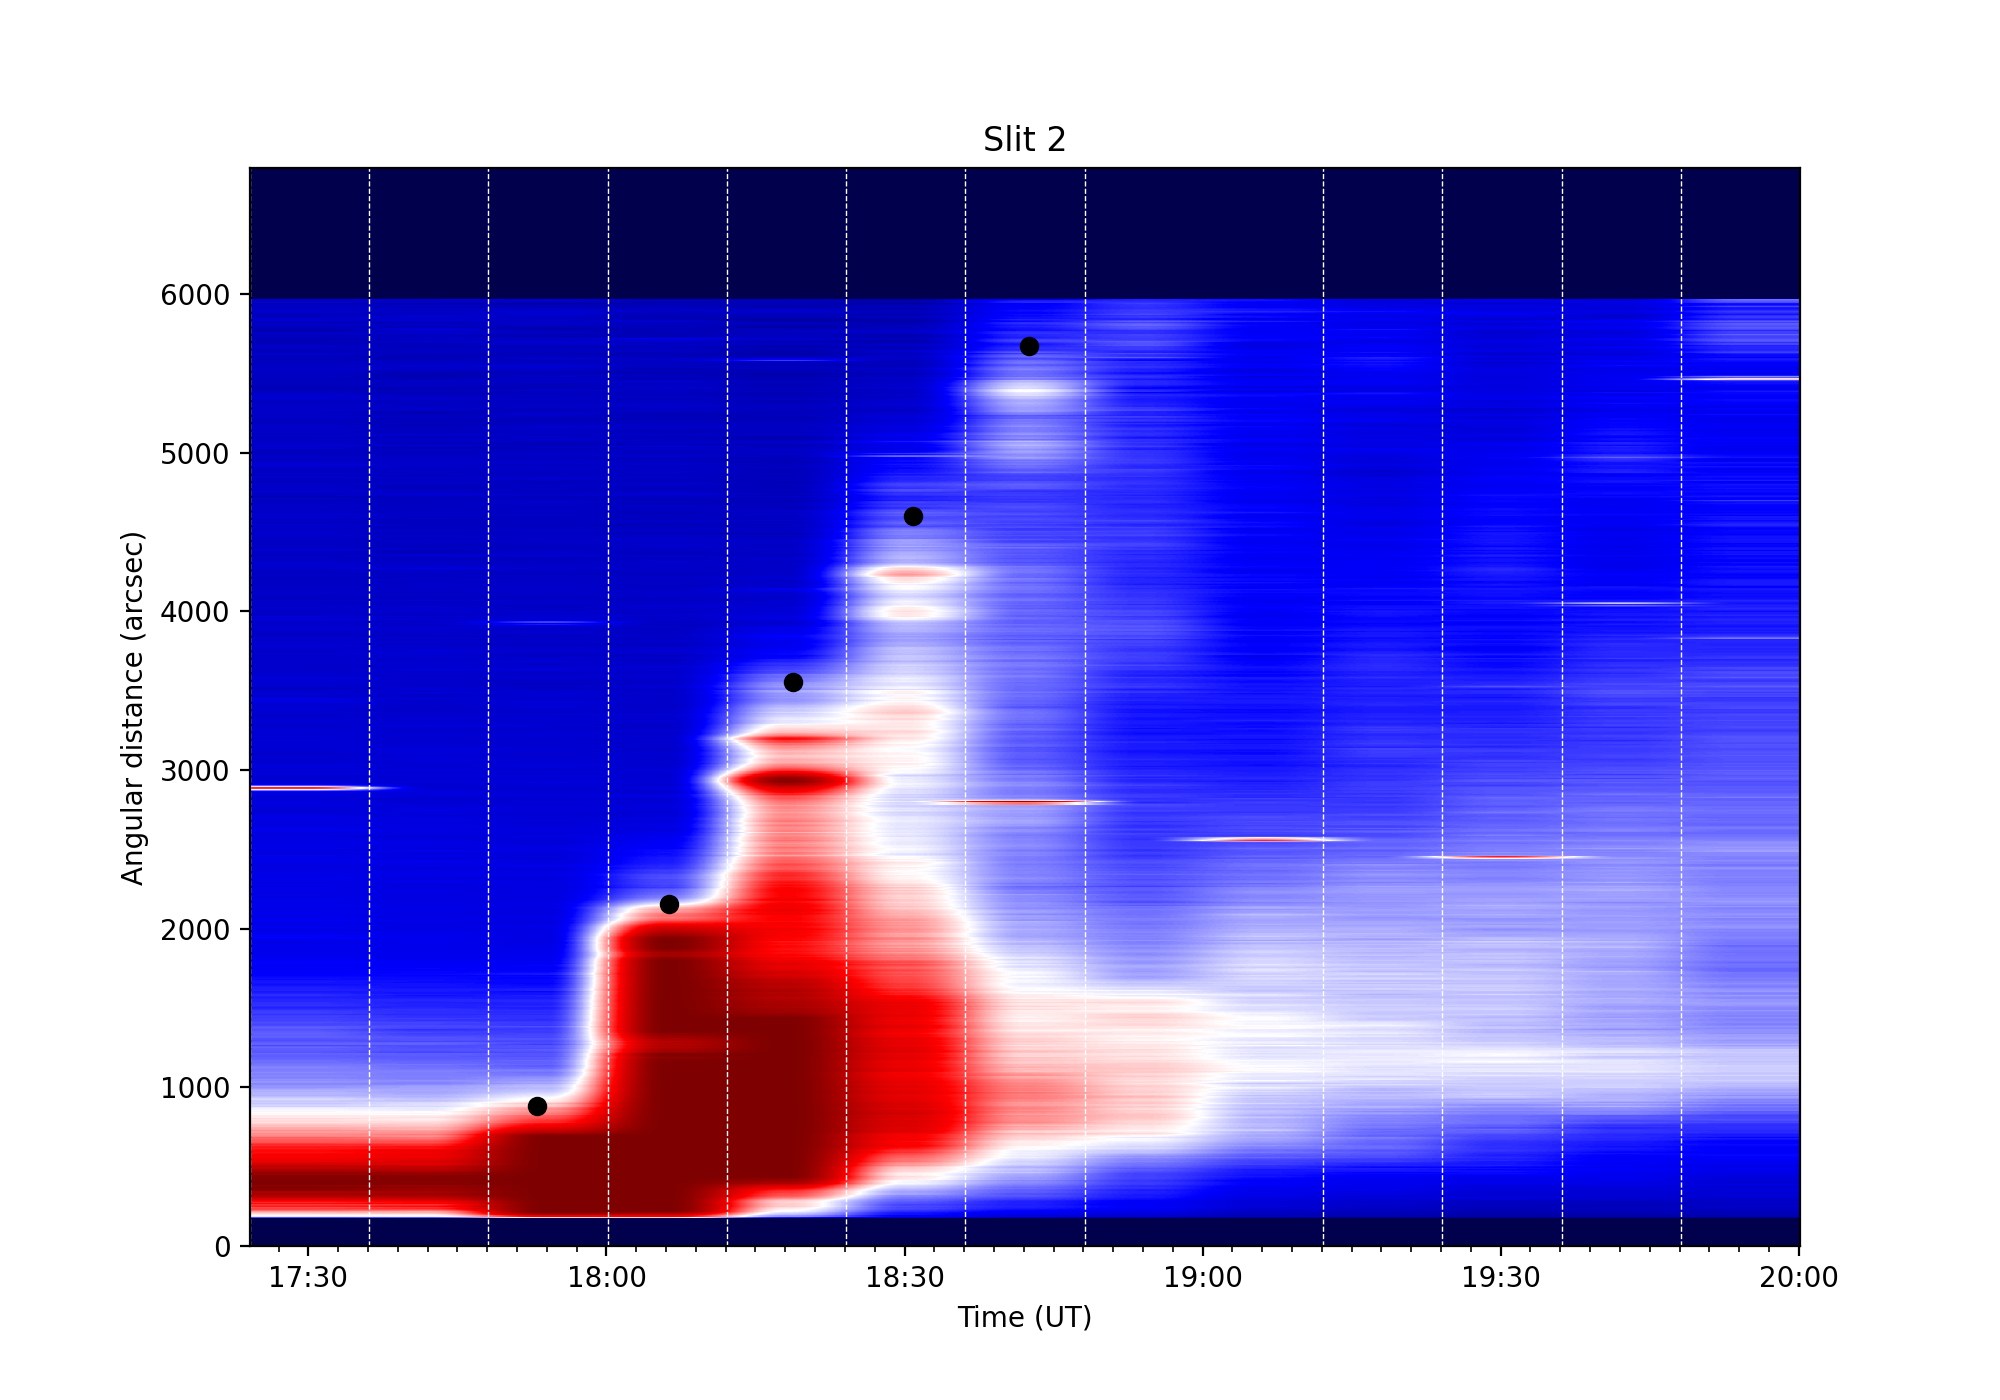

In [73]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity2'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance2'][0],
                output_obj['distance2'][-1]])

for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 2')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

# List to store coordinates
feature_coords_slit2 = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            feature_coords_slit2.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

<IPython.core.display.Javascript object>


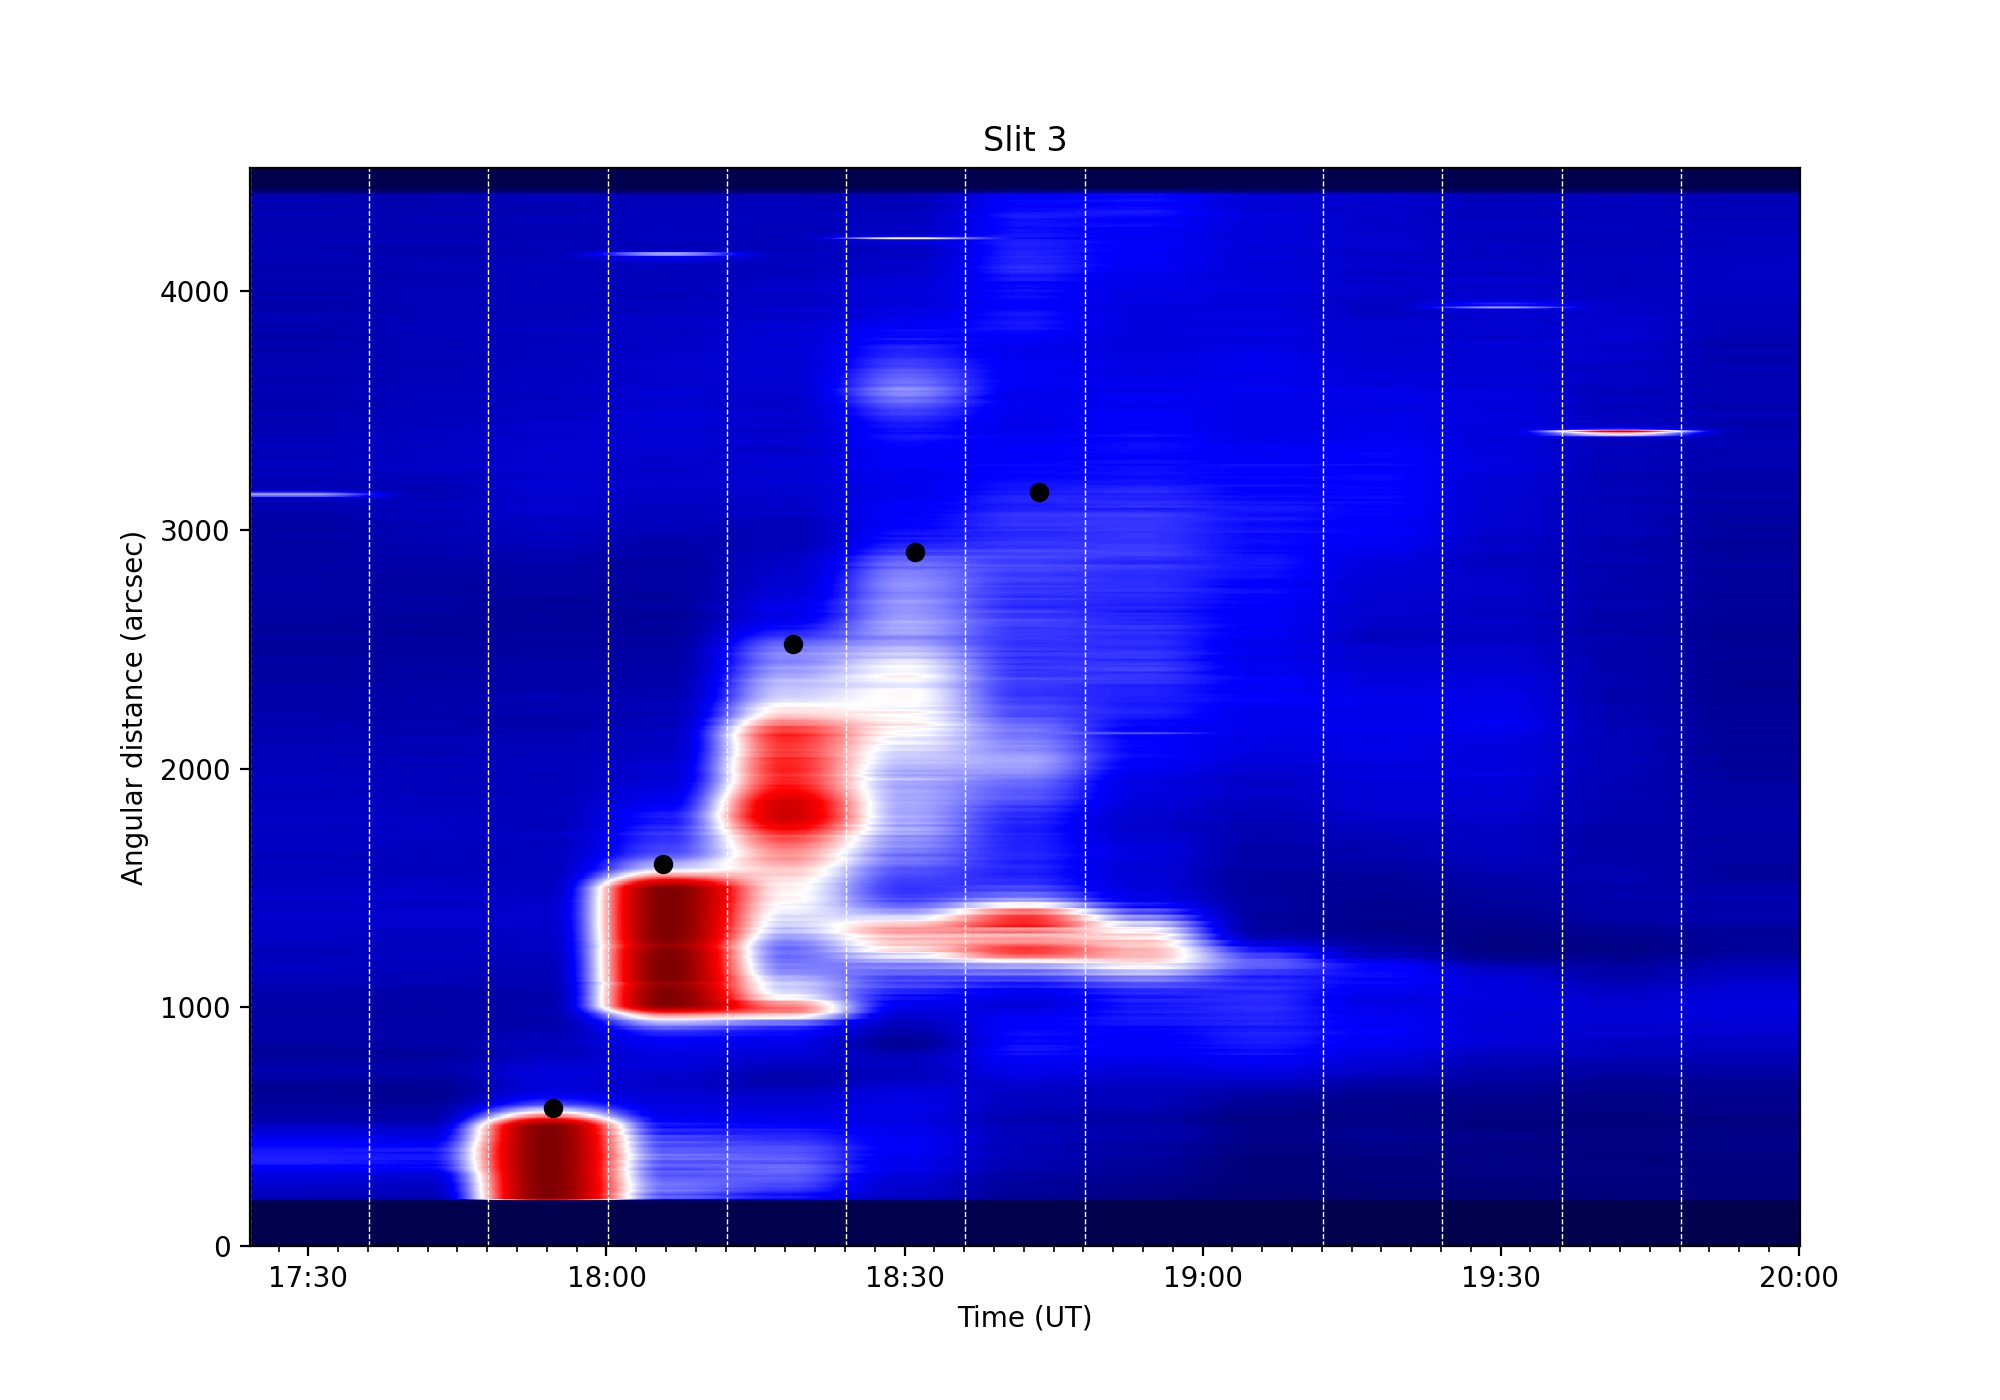

In [74]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity3'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance3'][0],
                output_obj['distance3'][-1]])

for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 3')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

# List to store coordinates
feature_coords_slit3 = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            feature_coords_slit3.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [88]:
df_jplot1 = pd.DataFrame(feature_coords_slit1, columns=['time','distance1'])
df_jplot2 = pd.DataFrame(feature_coords_slit2, columns=['time','distance2'])
df_jplot3 = pd.DataFrame(feature_coords_slit3, columns=['time','distance3'])

In [89]:
# Fitting the points

# Extract time and distance arrays from the selected coordinates
times_f, distances = zip(*feature_coords_slit1)

# Convert times to matplotlib date numbers
times_num = np.array(times_f)

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'].rsun_obs
print(conversion_factor)



# convert distance from arcsec to km
df_jplot1['distance_km'] = df_jplot1['distance1'] * conversion_factor

# calculate the distance difference in km
df_jplot1['distance_diff_km'] = df_jplot1['distance_km'].diff()

# convert time to datetime format
df_jplot1['datetime'] = [mdates.num2date(t) for t in df_jplot1['time']]

# calculate the time difference in seconds
df_jplot1['time_diff_s'] = df_jplot1['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df_jplot1['speed_km_s'] = df_jplot1['distance_diff_km'] / df_jplot1['time_diff_s']

# drop the first row which will have NaN values for the differences
df_jplot1.dropna(inplace=True)


# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=0)  # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s


# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.1163322825238 km / arcsec


<IPython.core.display.Javascript object>


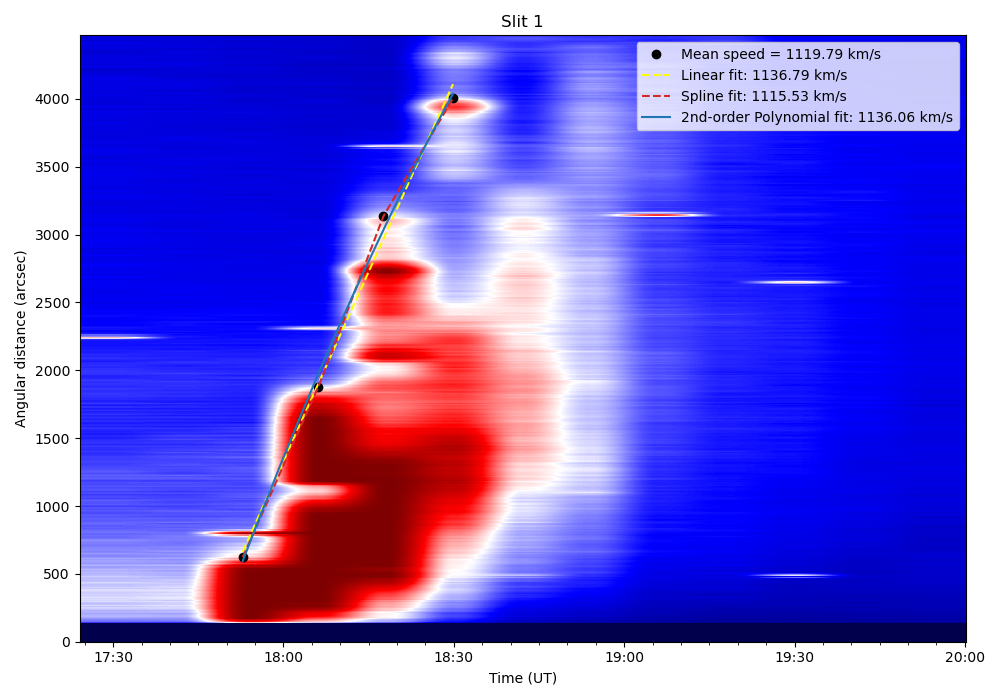

In [90]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity1'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance1'][0],
                output_obj['distance1'][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# Plot the fitted line
fit_line = slope * np.array(times_num) + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = df_jplot1['speed_km_s'].mean()

# Plot the selected points
ax.plot(times_num, distances, 'ko', label=f'Mean speed = {speed:.2f} km/s')
ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 1')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
ax.legend()

fig.tight_layout()
plt.show()

In [91]:
# Fitting the points

# Extract time and distance arrays from the selected coordinates
times_f, distances = zip(*feature_coords_slit2)

# Convert times to matplotlib date numbers
times_num = np.array(times_f)

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'].rsun_obs
print(conversion_factor)



# convert distance from arcsec to km
df_jplot2['distance_km'] = df_jplot2['distance2'] * conversion_factor

# calculate the distance difference in km
df_jplot2['distance_diff_km'] = df_jplot2['distance_km'].diff()

# convert time to datetime format
df_jplot2['datetime'] = [mdates.num2date(t) for t in df_jplot2['time']]

# calculate the time difference in seconds
df_jplot2['time_diff_s'] = df_jplot2['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df_jplot2['speed_km_s'] = df_jplot2['distance_diff_km'] / df_jplot2['time_diff_s']

# drop the first row which will have NaN values for the differences
df_jplot2.dropna(inplace=True)


# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=0)  # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s


# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.1163322825238 km / arcsec


<IPython.core.display.Javascript object>


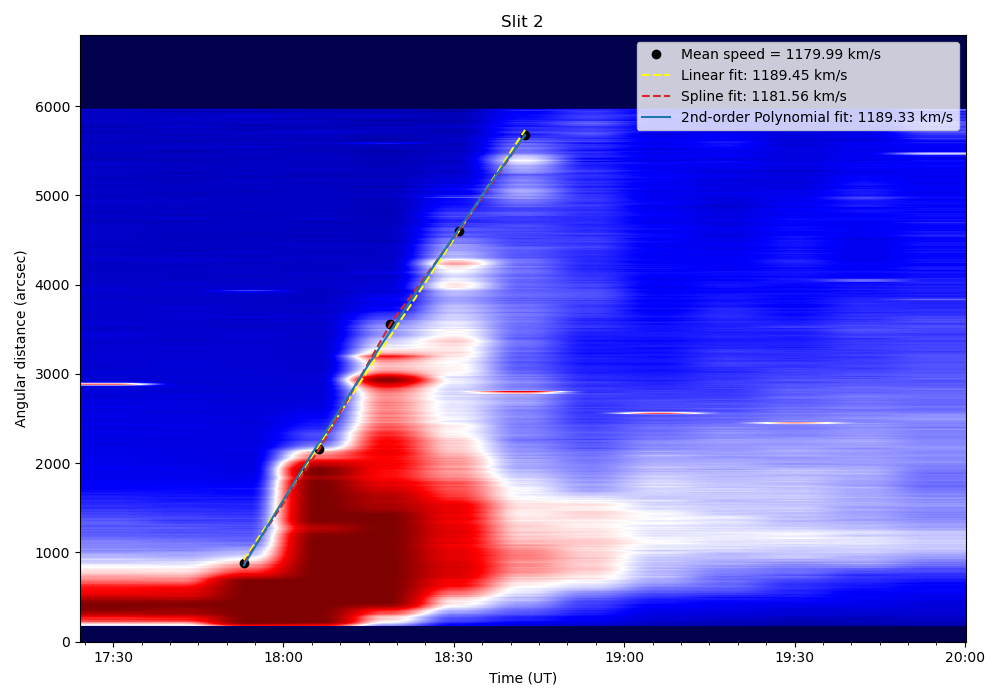

In [92]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity2'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance2'][0],
                output_obj['distance2'][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# Plot the fitted line
fit_line = slope * np.array(times_num) + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = df_jplot2['speed_km_s'].mean()

# Plot the selected points
ax.plot(times_num, distances, 'ko', label=f'Mean speed = {speed:.2f} km/s')
ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 2')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
ax.legend()

fig.tight_layout()
plt.show()

In [93]:
# Fitting the points

# Extract time and distance arrays from the selected coordinates
times_f, distances = zip(*feature_coords_slit3)

# Convert times to matplotlib date numbers
times_num = np.array(times_f)

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'].rsun_obs
print(conversion_factor)



# convert distance from arcsec to km
df_jplot3['distance_km'] = df_jplot3['distance3'] * conversion_factor

# calculate the distance difference in km
df_jplot3['distance_diff_km'] = df_jplot3['distance_km'].diff()

# convert time to datetime format
df_jplot3['datetime'] = [mdates.num2date(t) for t in df_jplot3['time']]

# calculate the time difference in seconds
df_jplot3['time_diff_s'] = df_jplot3['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df_jplot3['speed_km_s'] = df_jplot3['distance_diff_km'] / df_jplot3['time_diff_s']

# drop the first row which will have NaN values for the differences
df_jplot3.dropna(inplace=True)


# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=0)  # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s


# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.1163322825238 km / arcsec


<IPython.core.display.Javascript object>


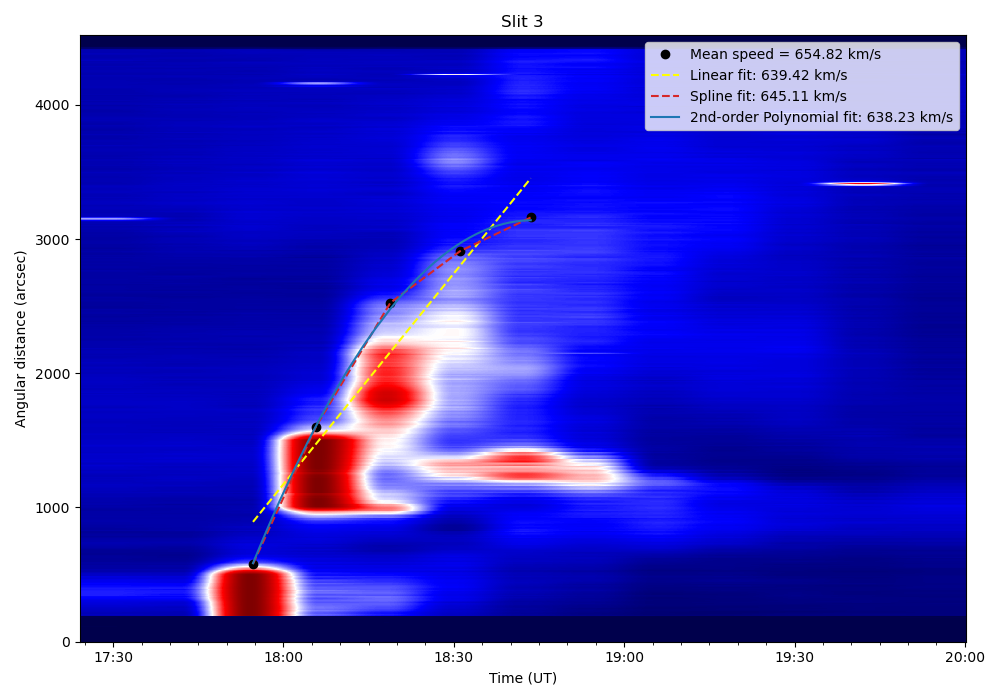

In [94]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity3'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[datenum_arr[0], datenum_arr[-1],
                output_obj['distance3'][0],
                output_obj['distance3'][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# Plot the fitted line
fit_line = slope * np.array(times_num) + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = df_jplot3['speed_km_s'].mean()

# Plot the selected points
ax.plot(times_num, distances, 'ko', label=f'Mean speed = {speed:.2f} km/s')
ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('Slit 3')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
ax.legend()

fig.tight_layout()
plt.show()

In [95]:
# export data points as tables
df_jplot1.to_csv('./jplot_c2_slit1.csv')
df_jplot2.to_csv('./jplot_c2_slit2.csv')
df_jplot3.to_csv('./jplot_c2_slit3.csv')